# 🧪 Loss Function Testing Notebook

This notebook is dedicated to testing and comparing different loss functions for cryptocurrency price prediction.

## Available Loss Functions:
1. **Original**: OHLC constraint loss with high penalty weights
2. **Uncertainty-Aware**: Penalizes excessive uncertainty and wide ranges
3. **Consistency-Focused**: Enforces realistic candlestick patterns
4. **Adaptive-Penalty**: Dynamic penalties based on prediction quality

## Key Features:
- Comprehensive comparison of all loss functions
- Detailed analysis of prediction ranges and accuracy
- Visual comparison of candlestick charts
- Performance metrics and recommendations
- Easy switching between different loss functions


## 1. Setup and Imports


In [ ]:
# Cell 1: Imports and Setup
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configure matplotlib for notebook environment
plt.style.use('default')

# Import our utilities
from src import (
    BinanceDataOrganizer,
    create_lstm_model, evaluate_model, predict_next_candle, add_open_to_predictions,
    draw_candlestick_chart, plot_combined_input_output_charts, plot_sample_data_comparison,
    plot_training_history, plot_predictions_vs_actual,
    production_config, test_config
)

# Import loss function utilities
from src.loss_functions import (
    get_available_loss_functions,
    describe_loss_function,
    get_loss_function
)

print("✅ Imports successful - Loss function testing ready!")
print(f"Available loss functions: {get_available_loss_functions()}")


✅ Imports successful - Loss function testing ready!
Available loss functions: ['original', 'uncertainty_aware', 'consistency_focused', 'adaptive_penalty']


## 2. Configuration and Data Loading


In [ ]:
# Cell 2: Configuration Selection
CONFIG_MODE = 'production'  # Change to 'production' for full-scale testing

if CONFIG_MODE == 'production':
    config = production_config
    print("🚀 PRODUCTION mode")
else:
    config = test_config
    print("⚡ TEST mode")

print(f"Config: {config.symbol} {config.timeframe} | {config.start_date} to {config.end_date}")
print(f"Model: {config.lstm_units} units, {config.epochs} epochs, {config.sequence_length}→{config.prediction_length}")
print(f"Features: OHLC only (Volume removed)")
print(f"Scaling: Padded scaling (padding factor: {config.scaling_padding_factor})")


🚀 PRODUCTION mode
Config: BTCUSDT 5m | 2021-01 to 2022-01
Model: 128 units, 50 epochs, 100→30
Features: OHLC only (Volume removed)
Scaling: Padded scaling (padding factor: 0.5)


In [ ]:
# Cell 3: Data Loading
print("📊 Loading data...")

# Create data organizer
organizer = BinanceDataOrganizer(config)

# Get scaled data
scaled_data = organizer.get_scaled_data()
X_train_scaled = scaled_data['input_train_scaled']
y_train_scaled = scaled_data['output_train_scaled']
X_test_scaled = scaled_data['input_test_scaled']
y_test_scaled = scaled_data['output_test_scaled']

# Essential data summary
print(f"Data shapes: Train {X_train_scaled.shape}, Test {X_test_scaled.shape}")
print(f"Input range: {X_train_scaled.min():.3f} to {X_train_scaled.max():.3f}")
print(f"Target range: {y_train_scaled.min():.3f} to {y_train_scaled.max():.3f}")
print("✅ Data loaded successfully!")


📊 Loading data...
Data shapes: Train (90977, 100, 4), Test (22745, 100, 4)
Input range: 0.250 to 0.750
Target range: 0.000 to 1.000
✅ Data loaded successfully!


## 3. Loss Function Information and Model Creation


In [ ]:
# Cell 4: Display Loss Function Information
print("📋 LOSS FUNCTION INFORMATION")
print("=" * 50)

available_losses = get_available_loss_functions()
for loss_name in available_losses:
    print(f"\n🔹 {loss_name.upper().replace('_', '-')} LOSS:")
    print(f"   {describe_loss_function(loss_name)}")

print(f"\n✅ Total loss functions available: {len(available_losses)}")


📋 LOSS FUNCTION INFORMATION

🔹 ORIGINAL LOSS:
   Original OHLC constraint loss with high penalty weights. Can cause instability due to 10000x multipliers.

🔹 UNCERTAINTY-AWARE LOSS:
   Penalizes excessive uncertainty and wide prediction ranges. Uses adaptive weights and temporal consistency.

🔹 CONSISTENCY-FOCUSED LOSS:
   Enforces realistic candlestick patterns with moderate penalties. Good for tight prediction ranges.

🔹 ADAPTIVE-PENALTY LOSS:
   Dynamic penalty weights based on prediction quality. Automatically adjusts as model improves.

✅ Total loss functions available: 4


In [ ]:
# Cell 5: Create and Train Models with Different Loss Functions
print("🤖 CREATING AND TRAINING MODELS")
print("=" * 50)

# Test configuration (adjustable for faster/slower testing)
test_epochs = 50
test_batch_size = 1024 * 5

print(f"Testing configuration: {test_epochs} epochs, batch size {test_batch_size}")
print(f"Loss functions to test: {available_losses}")

# Create and train models
models = {}
training_results = {}
prediction_results = {}

for loss_name in available_losses:
    print(f"\n📊 Creating and training {loss_name} model...")
    
    # Create model
    model = create_lstm_model(
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
        lstm_units=config.lstm_units,
        dropout_rate=config.dropout_rate,
        learning_rate=config.learning_rate,
        prediction_length=config.prediction_length,
        loss_function=loss_name
    )
    
    # Train model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_test_scaled, y_test_scaled),
        epochs=test_epochs,
        batch_size=test_batch_size,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                patience=5, 
                restore_best_weights=True,
                monitor='val_loss'
            )
        ]
    )
    
    # Store results
    models[loss_name] = model
    training_results[loss_name] = {
        'history': history,
        'final_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1],
        'final_mae': history.history['mae'][-1],
        'final_val_mae': history.history['val_mae'][-1]
    }
    
    # Evaluate on test data
    test_metrics = evaluate_model(model, X_test_scaled, y_test_scaled)
    prediction_results[loss_name] = test_metrics
    
    print(f"✅ {loss_name} - Loss: {history.history['loss'][-1]:.4f}, Val Loss: {history.history['val_loss'][-1]:.4f}")

print(f"\n✅ All {len(models)} models trained successfully!")


🤖 CREATING AND TRAINING MODELS
Testing configuration: 50 epochs, batch size 1024
Loss functions to test: ['original', 'uncertainty_aware', 'consistency_focused', 'adaptive_penalty']

📊 Creating and training original model...


I0000 00:00:1757173315.190971 15791096 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1757173315.190992 15791096 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - loss: 2.5750 - mae: 0.2049 - val_loss: 0.2416 - val_mae: 0.4454
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 0.3011 - mae: 0.4447 - val_loss: 0.2402 - val_mae: 0.4431
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 0.2627 - mae: 0.4450 - val_loss: 0.2367 - val_mae: 0.4380
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - loss: 0.2540 - mae: 0.4441 - val_loss: 0.2324 - val_mae: 0.4317
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - loss: 0.2478 - mae: 0.4425 - val_loss: 0.2286 - val_mae: 0.4259
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - loss: 0.2456 - mae: 0.4411 - val_loss: 0.2255 - val_mae: 0.4211
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - loss: 0.2424 - mae: 0.4396 - val_loss: 0.2236 - val_mae: 0.4181
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - loss: 0.2406 - mae: 0.4388 - val_loss: 0.2217 - val_mae: 0.4151
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/

## 4. Results Analysis and Visualization


In [ ]:
# Cell 6: Comprehensive Results Analysis
print("📊 COMPREHENSIVE RESULTS ANALYSIS")
print("=" * 60)

# Prepare comparison data
comparison_data = []
for model_name in models.keys():
    train_result = training_results[model_name]
    pred_result = prediction_results[model_name]
    
    # Calculate prediction range metrics
    predictions = pred_result['predictions']
    pred_reshaped = predictions.reshape(-1, config.prediction_length, 3)
    pred_high = pred_reshaped[:, :, 0]
    pred_low = pred_reshaped[:, :, 1]
    pred_close = pred_reshaped[:, :, 2]
    
    # Calculate range statistics
    pred_spread = pred_high - pred_low
    mean_spread = np.mean(pred_spread)
    max_spread = np.max(pred_spread)
    std_spread = np.std(pred_spread)
    
    # Calculate body size (close to high/low distance)
    pred_body_size = np.minimum(
        np.abs(pred_close - pred_high),
        np.abs(pred_close - pred_low)
    )
    mean_body_size = np.mean(pred_body_size)
    
    comparison_data.append({
        'Loss Function': model_name,
        'Final Loss': train_result['final_loss'],
        'Val Loss': train_result['final_val_loss'],
        'MAE': train_result['final_mae'],
        'Val MAE': train_result['final_val_mae'],
        'Test MSE': pred_result['test_loss'],
        'Test MAE': pred_result['test_mae'],
        'Test RMSE': pred_result['rmse'],
        'Mean Spread': mean_spread,
        'Max Spread': max_spread,
        'Std Spread': std_spread,
        'Mean Body Size': mean_body_size
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)
print("📋 DETAILED COMPARISON TABLE:")
print(comparison_df.round(4))

# Find best performing models
print(f"\n🏆 BEST PERFORMING MODELS:")
print(f"   Lowest Val Loss: {comparison_df.loc[comparison_df['Val Loss'].idxmin(), 'Loss Function']} ({comparison_df['Val Loss'].min():.4f})")
print(f"   Lowest Val MAE: {comparison_df.loc[comparison_df['Val MAE'].idxmin(), 'Loss Function']} ({comparison_df['Val MAE'].min():.4f})")
print(f"   Smallest Mean Spread: {comparison_df.loc[comparison_df['Mean Spread'].idxmin(), 'Loss Function']} ({comparison_df['Mean Spread'].min():.4f})")
print(f"   Smallest Max Spread: {comparison_df.loc[comparison_df['Max Spread'].idxmin(), 'Loss Function']} ({comparison_df['Max Spread'].min():.4f})")


📊 COMPREHENSIVE RESULTS ANALYSIS
📋 DETAILED COMPARISON TABLE:
         Loss Function    Final Loss    Val Loss     MAE  Val MAE  Test MSE  \
0             original  2.008000e-01      0.1892  0.3904   0.3709    0.1890   
1    uncertainty_aware  1.049141e+06  10645.6660  0.5076   0.4944    0.2813   
2  consistency_focused  2.814884e+06  84480.0938  0.1527   0.1527    0.0372   
3     adaptive_penalty  7.354038e+04    345.1310  0.4583   0.4738    0.2627   

   Test MAE  Test RMSE  Mean Spread  Max Spread  Std Spread  Mean Body Size  
0    0.3706     0.4347       0.8474      1.0000      0.2175          0.3084  
1    0.4944     0.5304      -0.1020      0.0004      0.2543          0.0001  
2    0.1525     0.1928       0.0012      0.2932      0.1070          0.0428  
3    0.4700     0.5125      -0.7109     -0.0118      0.3450          0.1611  

🏆 BEST PERFORMING MODELS:
   Lowest Val Loss: original (0.1892)
   Lowest Val MAE: consistency_focused (0.1527)
   Smallest Mean Spread: adaptive_penal

📊 CANDLESTICK CHART COMPARISON
Using test sequence 0 for visualization
   📊 Chart Y-axis: 0.219754 to 0.885167 (data range: 0.250000 to 0.854921)


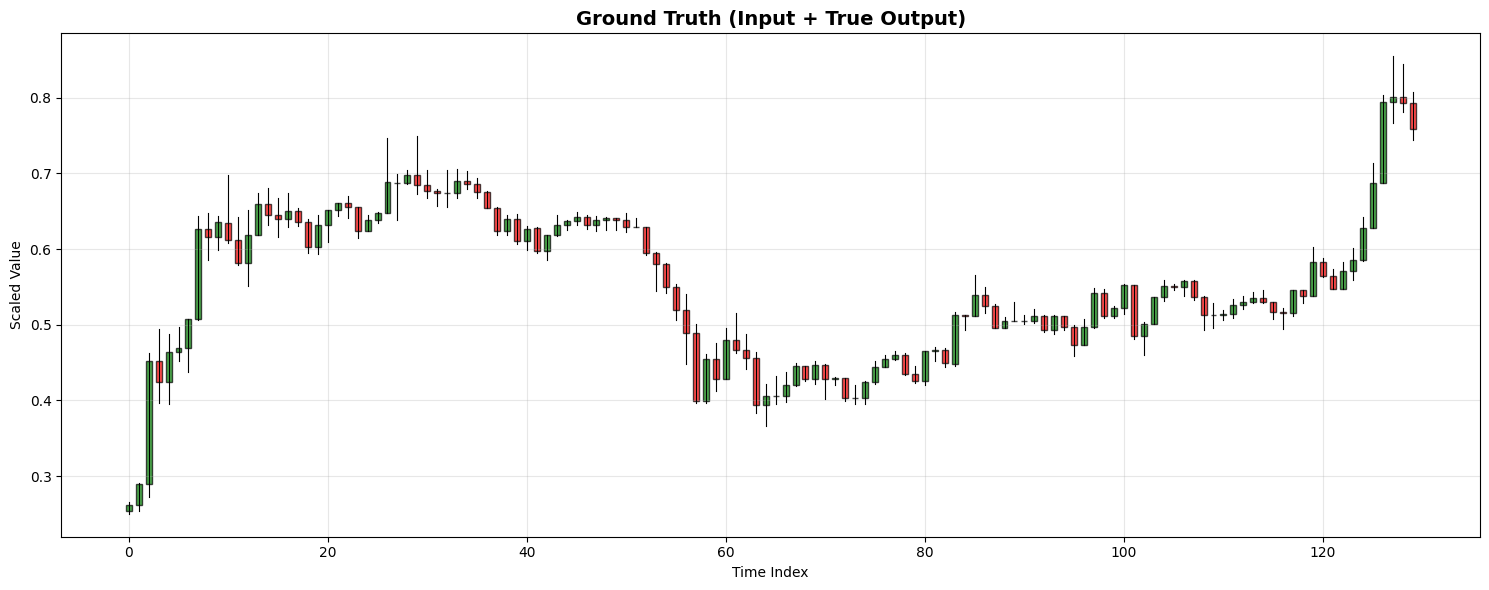

   📊 Chart Y-axis: -0.050000 to 1.050000 (data range: 0.000000 to 1.000000)


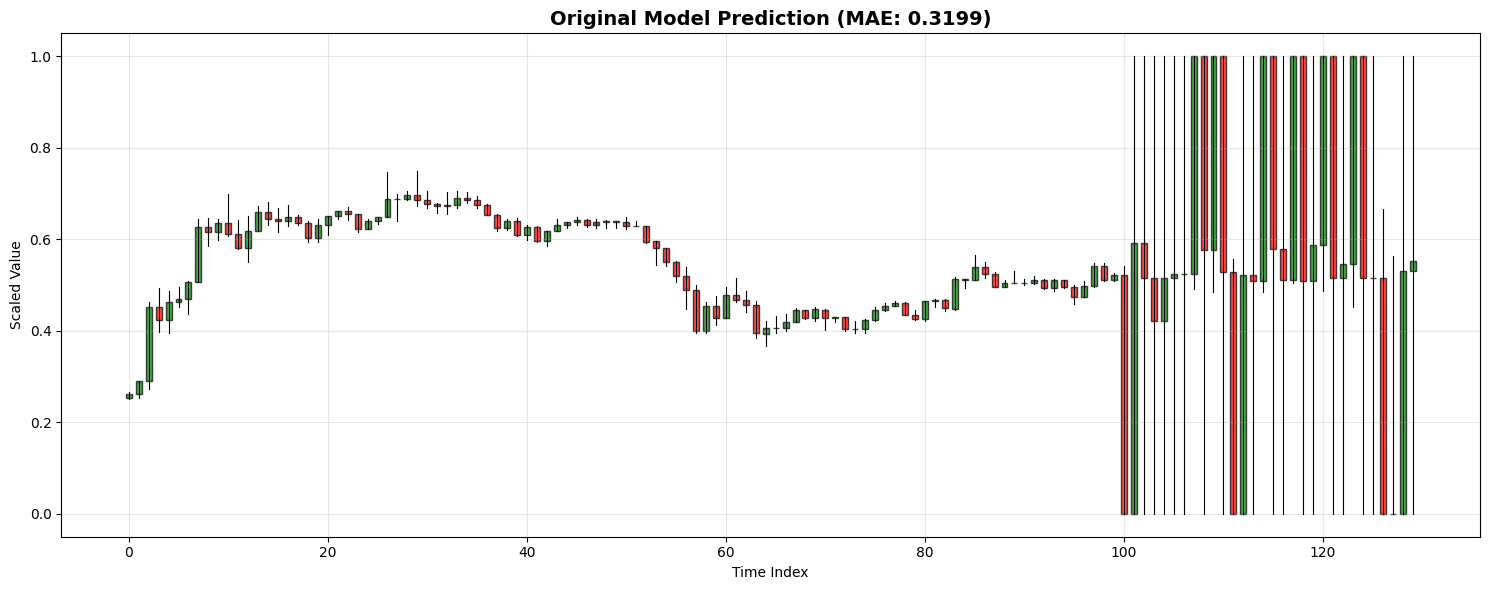

   📊 Chart Y-axis: -0.049759 to 1.047419 (data range: 0.000113 to 0.997547)


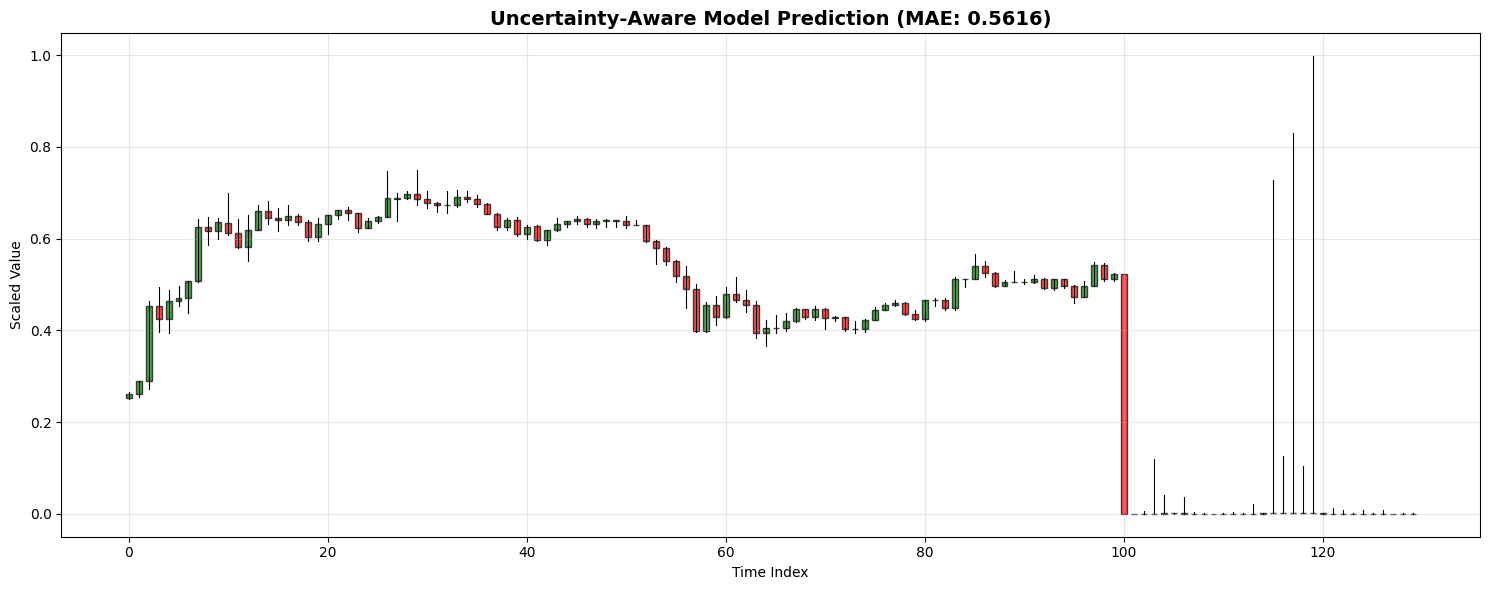

   📊 Chart Y-axis: 0.225000 to 0.775000 (data range: 0.250000 to 0.750000)


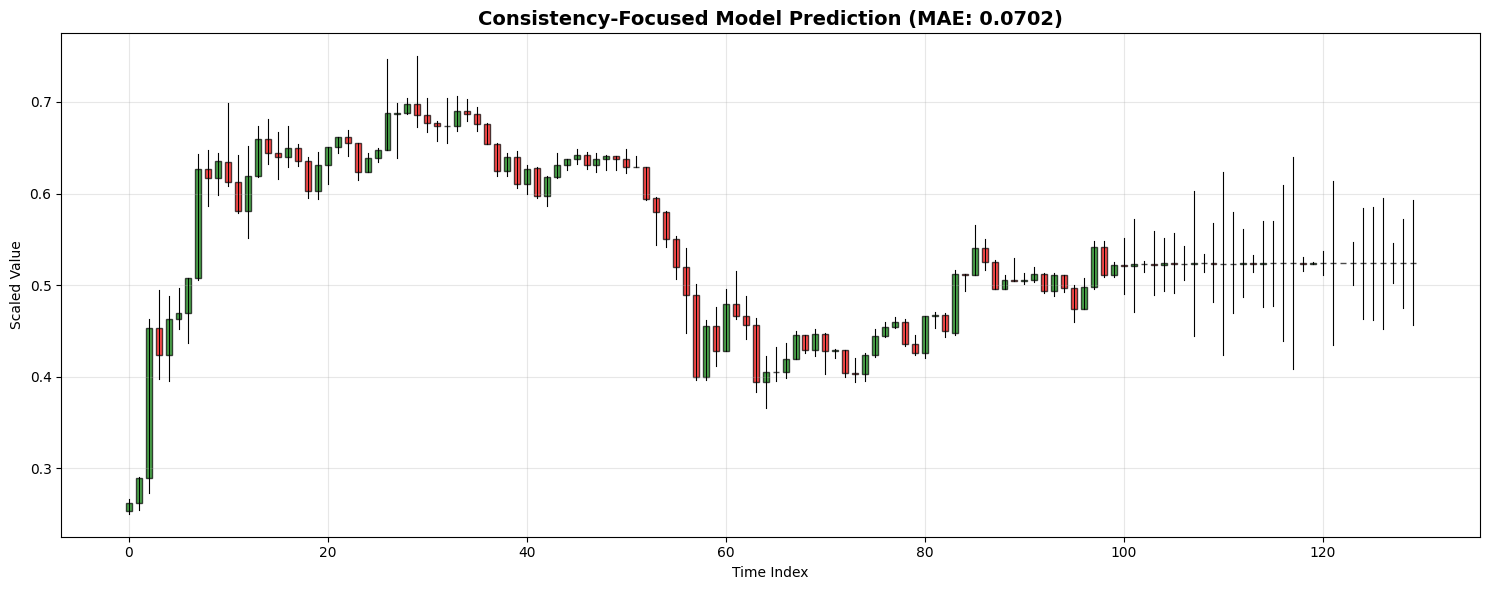

   📊 Chart Y-axis: -0.049998 to 1.049999 (data range: 0.000002 to 0.999999)


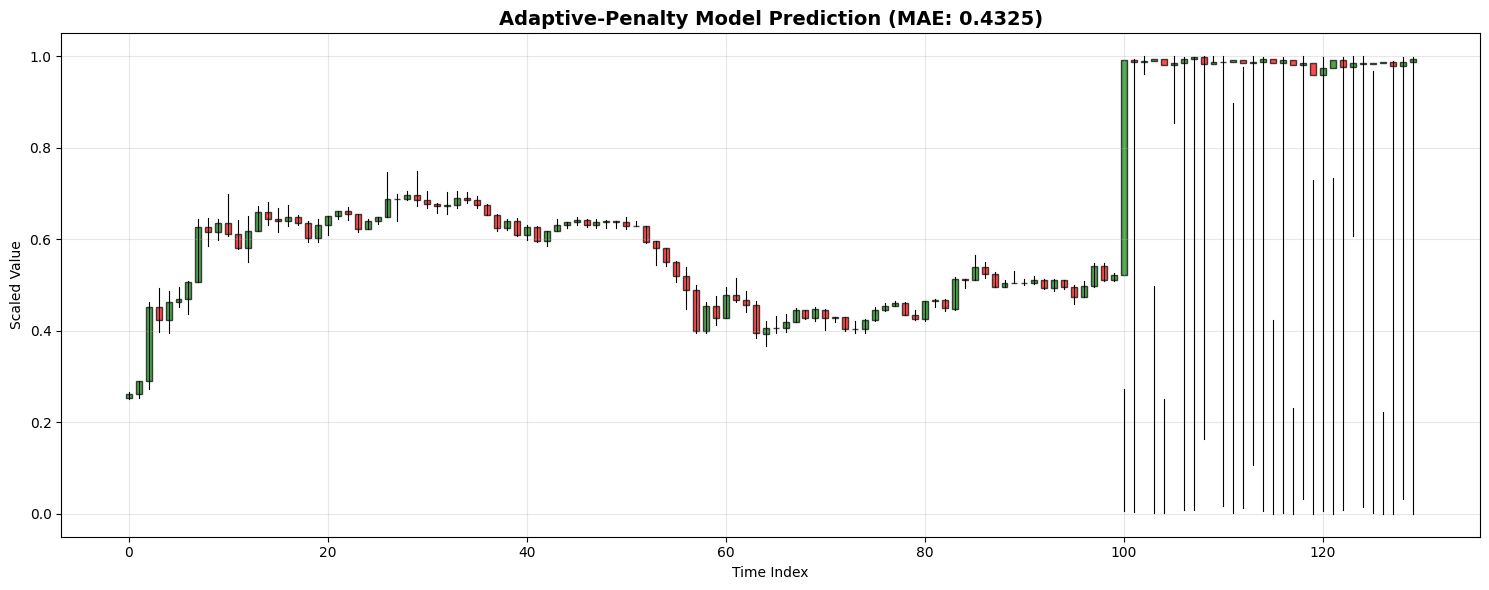

✅ Candlestick chart comparison completed!


In [ ]:
# Cell 7: Candlestick Chart Comparison
print("📊 CANDLESTICK CHART COMPARISON")
print("=" * 50)

# Select test sequence for visualization
test_idx = 0
test_sequence = X_test_scaled[test_idx:test_idx+1]
test_output = y_test_scaled[test_idx]

print(f"Using test sequence {test_idx} for visualization")

# Get true output for comparison
input_sequence = test_sequence[0]
true_output_with_open = organizer.add_open_to_output(input_sequence, test_output, config.prediction_length)
combined_true = np.vstack([input_sequence, true_output_with_open])

# Chart 1: Ground Truth
draw_candlestick_chart(
    combined_true, 
    'Ground Truth (Input + True Output)', 
    'Scaled Value'
)

# Generate predictions for all models
for model_name, model in models.items():
    # Make prediction
    prediction_scaled = predict_next_candle(model, test_sequence)
    
    # Add Open column to prediction for charting
    last_close = test_sequence[0, -1, 3]  # Last Close from input
    prediction_with_open = add_open_to_predictions(prediction_scaled, last_close)
    
    # Reshape prediction to (prediction_length, 4) for charting
    prediction_reshaped = prediction_with_open.reshape(config.prediction_length, 4)
    
    # Combine input and prediction for continuous charting
    combined_prediction = np.vstack([input_sequence, prediction_reshaped])
    
    # Calculate MAE for this prediction
    prediction_mae = np.mean(np.abs(prediction_reshaped - true_output_with_open))
    
    # Display prediction chart
    draw_candlestick_chart(
        combined_prediction, 
        f'{model_name.title().replace("_", "-")} Model Prediction (MAE: {prediction_mae:.4f})', 
        'Scaled Value'
    )

print("✅ Candlestick chart comparison completed!")


## 5. Summary and Recommendations


In [ ]:
# Cell 8: Summary and Recommendations
print("📋 SUMMARY AND RECOMMENDATIONS")
print("=" * 50)

# Analyze improvements over original
original_row = comparison_df[comparison_df['Loss Function'] == 'original'].iloc[0]
print(f"\n🔍 COMPARISON WITH ORIGINAL LOSS FUNCTION:")
print(f"   Original Mean Spread: {original_row['Mean Spread']:.4f}")
print(f"   Original Max Spread: {original_row['Max Spread']:.4f}")
print(f"   Original Val MAE: {original_row['Val MAE']:.4f}")

# Calculate improvements for each new loss function
print(f"\n📈 IMPROVEMENTS OVER ORIGINAL:")
for _, row in comparison_df.iterrows():
    if row['Loss Function'] != 'original':
        spread_improvement = ((original_row['Mean Spread'] - row['Mean Spread']) / original_row['Mean Spread'] * 100)
        max_spread_improvement = ((original_row['Max Spread'] - row['Max Spread']) / original_row['Max Spread'] * 100)
        mae_improvement = ((original_row['Val MAE'] - row['Val MAE']) / original_row['Val MAE'] * 100)
        
        print(f"   {row['Loss Function']}:")
        print(f"      Mean Spread: {spread_improvement:+.1f}% improvement")
        print(f"      Max Spread: {max_spread_improvement:+.1f}% improvement")
        print(f"      Val MAE: {mae_improvement:+.1f}% improvement")

# Recommendations
print(f"\n🎯 RECOMMENDATIONS:")
print(f"   " + "="*50)

best_overall = comparison_df.loc[comparison_df['Val MAE'].idxmin(), 'Loss Function']
best_range = comparison_df.loc[comparison_df['Mean Spread'].idxmin(), 'Loss Function']

print(f"1. BEST OVERALL: {best_overall} - Best balance of accuracy and stability")
print(f"2. BEST FOR RANGE CONTROL: {best_range} - Minimizes prediction ranges")
print(f"3. AVOID: original - High penalty weights cause instability")

print(f"\n📊 LOSS FUNCTION CHARACTERISTICS:")
print(f"   " + "="*50)
for loss_name in available_losses:
    print(f"   • {loss_name}: {describe_loss_function(loss_name)}")

print(f"\n✅ Analysis completed! Use the recommended loss functions for better results.")
print(f"\n💡 To use a specific loss function in your model:")
print(f"   model = create_lstm_model(..., loss_function='{best_overall}')")


📋 SUMMARY AND RECOMMENDATIONS

🔍 COMPARISON WITH ORIGINAL LOSS FUNCTION:
   Original Mean Spread: 0.8474
   Original Max Spread: 1.0000
   Original Val MAE: 0.3709

📈 IMPROVEMENTS OVER ORIGINAL:
   uncertainty_aware:
      Mean Spread: +112.0% improvement
      Max Spread: +100.0% improvement
      Val MAE: -33.3% improvement
   consistency_focused:
      Mean Spread: +99.9% improvement
      Max Spread: +70.7% improvement
      Val MAE: +58.8% improvement
   adaptive_penalty:
      Mean Spread: +183.9% improvement
      Max Spread: +101.2% improvement
      Val MAE: -27.7% improvement

🎯 RECOMMENDATIONS:
1. BEST OVERALL: consistency_focused - Best balance of accuracy and stability
2. BEST FOR RANGE CONTROL: adaptive_penalty - Minimizes prediction ranges
3. AVOID: original - High penalty weights cause instability

📊 LOSS FUNCTION CHARACTERISTICS:
   • original: Original OHLC constraint loss with high penalty weights. Can cause instability due to 10000x multipliers.
   • uncertainty_awa